# __Stack Overflow public survey 2017__
___
## __Section 1. Business Understanding__

Through the Stackoverflow public survey 2017 dataset, I am trying to extract information about what is considered the best way to break into the field of software developper. We will particularly be interested in the data related to Data Scientists.

Since I would like to get insights about successful professional positions, I will also be trying to model the salary of the respondents with the questions available in this survey. I would like to extract the variables that are the most important in the prediction of the salary.

---
## __Section 2. Data Understanding__
This public survey is of special interest to me because of one particular question coded ```CousinEducation``` which read as:
> _Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?_

This question is not found is the most recent public surveys, and will help us through this analysis.

To get the most relevant recommnedations from this dataset I will focus my attention to the respondents that have been recently hired in a new job.

In [2]:
# loading modules
import pandas as pd
import numpy as np
from IPython.display import Markdown as md
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.ticker as mtick

from stack_functions import getChoices, convert2USD, createDummyVar

/Users/sebastienvillard/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# setting up display
plt.style.use('fivethirtyeight')
# plt.style.use('tableau-colorblind10')
plt.rcParams['figure.figsize']= 8, 8
plt.rcParams['font.size']=8

### Load the dataset

In [4]:
# load data and data schema
df = pd.read_csv('../DataSets/StackOverflow/survey-results-public.csv')
df_sch = pd.read_csv('../DataSets/StackOverflow/survey-results-schema.csv')

### What kind of professional are represented in this dataset?

In [5]:
df_sch.query('Column == "Professional"')

,Column,Question
1,Professional,Which of the following best describes you?


In [6]:
md(f'>_There are "{df["Professional"].isna().sum()}" missing values in this category_')

>_There are "0" missing values in this category_

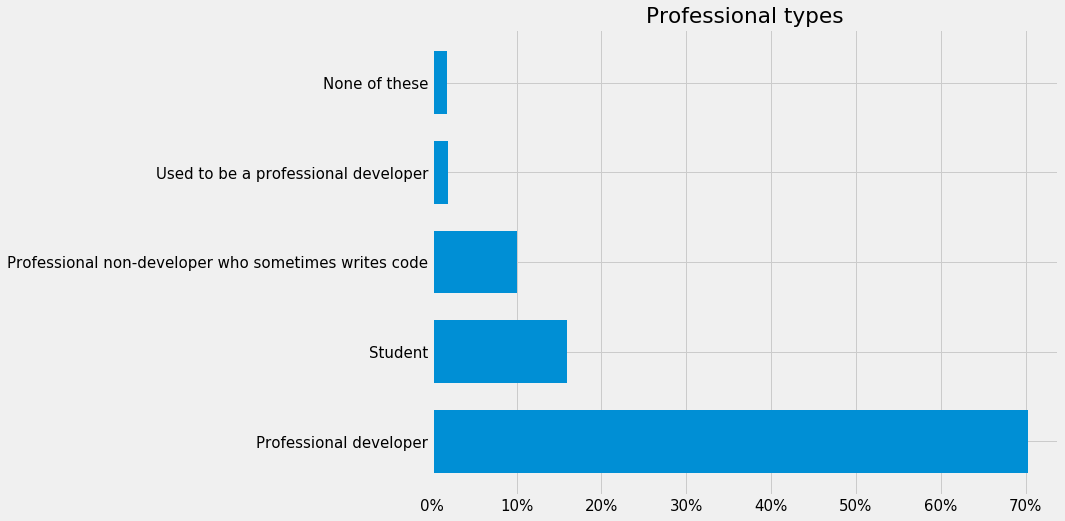

In [7]:
# shows count for each professional category
plt.rcParams['font.size']=15
plt.rcParams['figure.figsize']=10,8

perc_pro = df['Professional'].value_counts(normalize=True)
ax = perc_pro.plot(kind='barh', title='Professional types', width=.7)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))

> for the rest of this analysis we will focus on the __"Profesional developer"__ only

In [8]:
# We are keeping only "Professional developer"
df_pro = df.query('Professional == "Professional developer"')

### What is the proportion of Recent Hires (<= 4 years)?
We will restrict our analysis to new hires to have a better image of good advices for breaking into the field

In [9]:
txt = df_sch.query('Column == "LastNewJob"')['Question'].tolist()[0]
md(f'The Question read as:<br/> _{txt}_')

The Question read as:<br/> _When was the last time that you took a job with a new employer?_

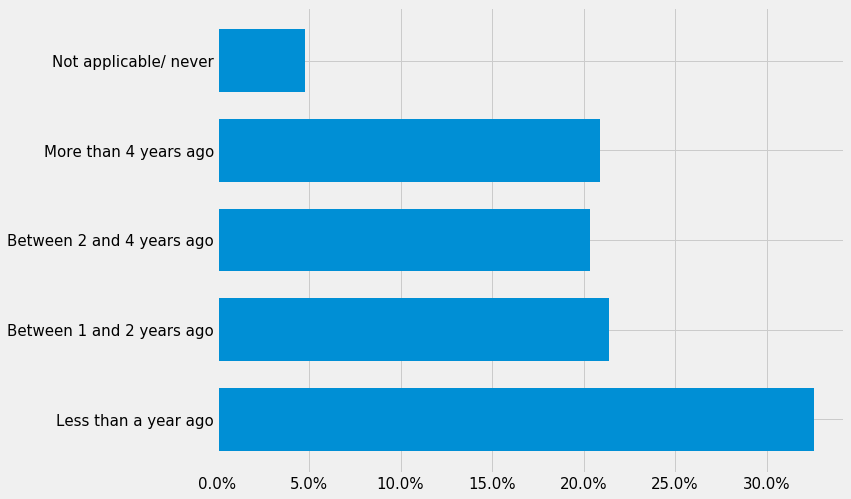

In [10]:
# percentage of responsdent by time in new job
per_nhires = df_pro['LastNewJob'].value_counts(normalize=True).reindex(index = 
                                                                      [
                                                                          'Less than a year ago',
                                                                          'Between 1 and 2 years ago',
                                                                          'Between 2 and 4 years ago',
                                                                          'More than 4 years ago',
                                                                          'Not applicable/ never'
                                                                      ]
                                                                     )

ax_nhires = per_nhires.plot(kind='barh', width=0.7)
ax_nhires.xaxis.set_major_formatter(mtick.PercentFormatter(1))

In [11]:
df_nhires = df_pro.query('LastNewJob in ["Less than a year ago","Between 1 and 2 years ago","Between 2 and 4 years ago"]')
# df_nhires = df_pro.query('LastNewJob in ["Less than a year ago","Between 1 and 2 years ago"]')

___
## __Section 3. Preparing data__

What should we do to ready our data to anser the question

### Education Advices from "Recent Hires Professional"
__What is the best way to enter the field?__

> We are using the ```getChoices()``` function to extract all unique possible choices in ```'CousinEducation'``` -> we will obtain all observations where each unique choices were found


In [11]:
txt = df_sch.query('Column == "CousinEducation"')['Question'].values[0].replace('\n', '<br/>')
md(f'__The Question read as:__<br/> _{txt}_')

__The Question read as:__<br/> _Let's pretend you have a distant cousin. They are 24 years old, have a college degree in a field not related to computer programming, and have been working a non-coding job for the last two years. They want your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to your cousin?<br/>Let's pretend you have a distant cousin named Robert. He is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. He wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Robert?<br/>Let's pretend you have a distant cousin named Alice. She is 24 years old, has a college degree in a field not related to computer programming, and has been working a non-coding job for the last two years. She wants your advice on how to switch to a career as a software developer. Which of the following options would you most strongly recommend to Alice?_

In [12]:
dictEducAdv = getChoices(df_nhires['CousinEducation'])
# count values for each category of 'CousinEducation' 
AdvCount = {k: len(v) for k, v in dictEducAdv.items()}
AdvCount

{'Get a job as a QA tester': 1477,
 'Take online courses': 5859,
 'Contribute to open source': 2842,
 'Part-time/evening courses': 2853,
 'Participate in online coding competitions': 1310,
 'Buy books and work through the exercises': 4395,
 'Conferences/meet-ups': 2166,
 "Master's degree": 956,
 'Return to college': 1818,
 'Participate in hackathons': 1069,
 'Other': 932,
 'Bootcamp': 2096,
 'None of these': 179}

Text(0.5, 1.0, 'What would you most strongly recommend to your cousin?')

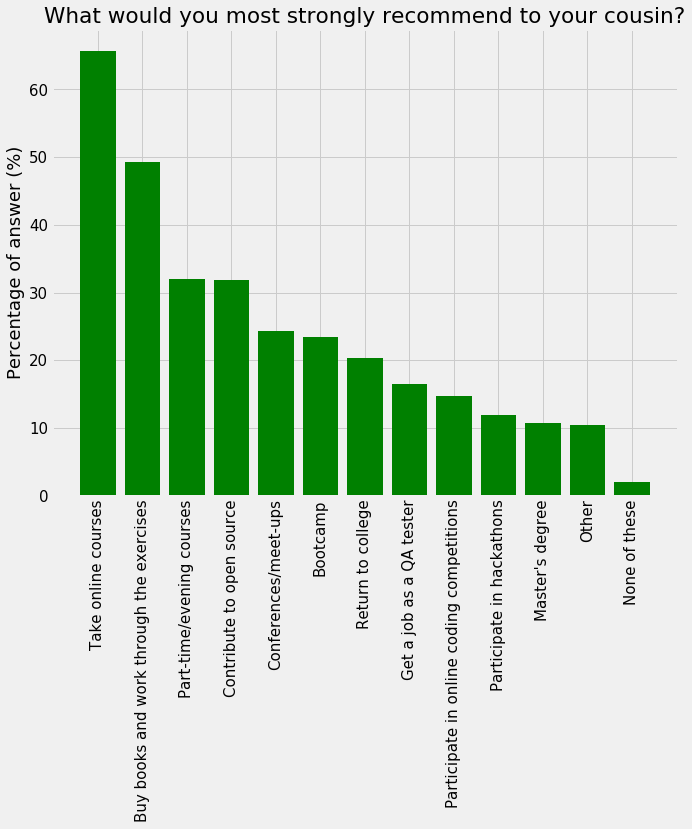

In [13]:
# first we reorder answers by count
mask = ~df_nhires['CousinEducation'].isna()
total_respondent = mask.sum()

AdvCount = dict(sorted(AdvCount.items(), key=lambda x: x[1], reverse=True)) ## reorder dictionnary
perc_Adv = np.array(list(AdvCount.values()))/total_respondent # compute percentage over respondent that answer this question

plt.bar(list(AdvCount.keys()), perc_Adv*100, color='g')
plt.ylabel('Percentage of answer (%)')
plt.xticks(rotation=90)
plt.title('What would you most strongly recommend to your cousin?')

### __How to break into the field?__

In [14]:
pos_str = ['1st', '2nd', '3rd']
txt = ''
for pos in range(len(pos_str)):
    txt += (f'The {pos_str[pos]} most given advice is to _"{list(AdvCount.keys())[pos]}"_ with __{perc_Adv[pos]:.2%}__ of the votes.<br/>')

md(txt)

The 1st most given advice is to _"Take online courses"_ with __65.62%__ of the votes.<br/>The 2nd most given advice is to _"Buy books and work through the exercises"_ with __49.23%__ of the votes.<br/>The 3rd most given advice is to _"Part-time/evening courses"_ with __31.96%__ of the votes.<br/>

> About 66% of the recent hires advice to Take online classes to switch their career to a software developer

### __How did the Recent Hires break into the field?__
We will explore their formal education and their training to investigate how they did get their new job.

In [15]:
txt1 = df_sch.query('Column == "FormalEducation"')['Question'].values[0]
txt2 = df_sch.query('Column == "EducationTypes"')['Question'].values[0]
md(
    f'We will focus first on __Formal Education__: <br/> _{txt1}_<br/>'
    +f'Then, we will look at __Education types__: <br/> _{txt2}_'
)


We will focus first on __Formal Education__: <br/> _Which of the following best describes the highest level of formal education that you've completed?_<br/>Then, we will look at __Education types__: <br/> _Outside of your formal schooling and education, which of the following have you done?_

In [16]:
dictEducType = getChoices(df_nhires['EducationTypes'])

# count values for each category of 'Training' 
EdTypeCount = {k: len(v) for k, v in dictEducType.items()}

# first we reorder answers by count
EdTypeCount = dict(sorted(EdTypeCount.items(), key=lambda x: x[1], reverse=True)) ## reorder dictionnary
perc_EdType = np.array(list(EdTypeCount.values()))/len(df_nhires) # compute percentage over all participants

# count values for each category of 'Formal Education' 
FormalEdu = df_nhires['FormalEducation'].value_counts(normalize=True)

(0.0, 60)

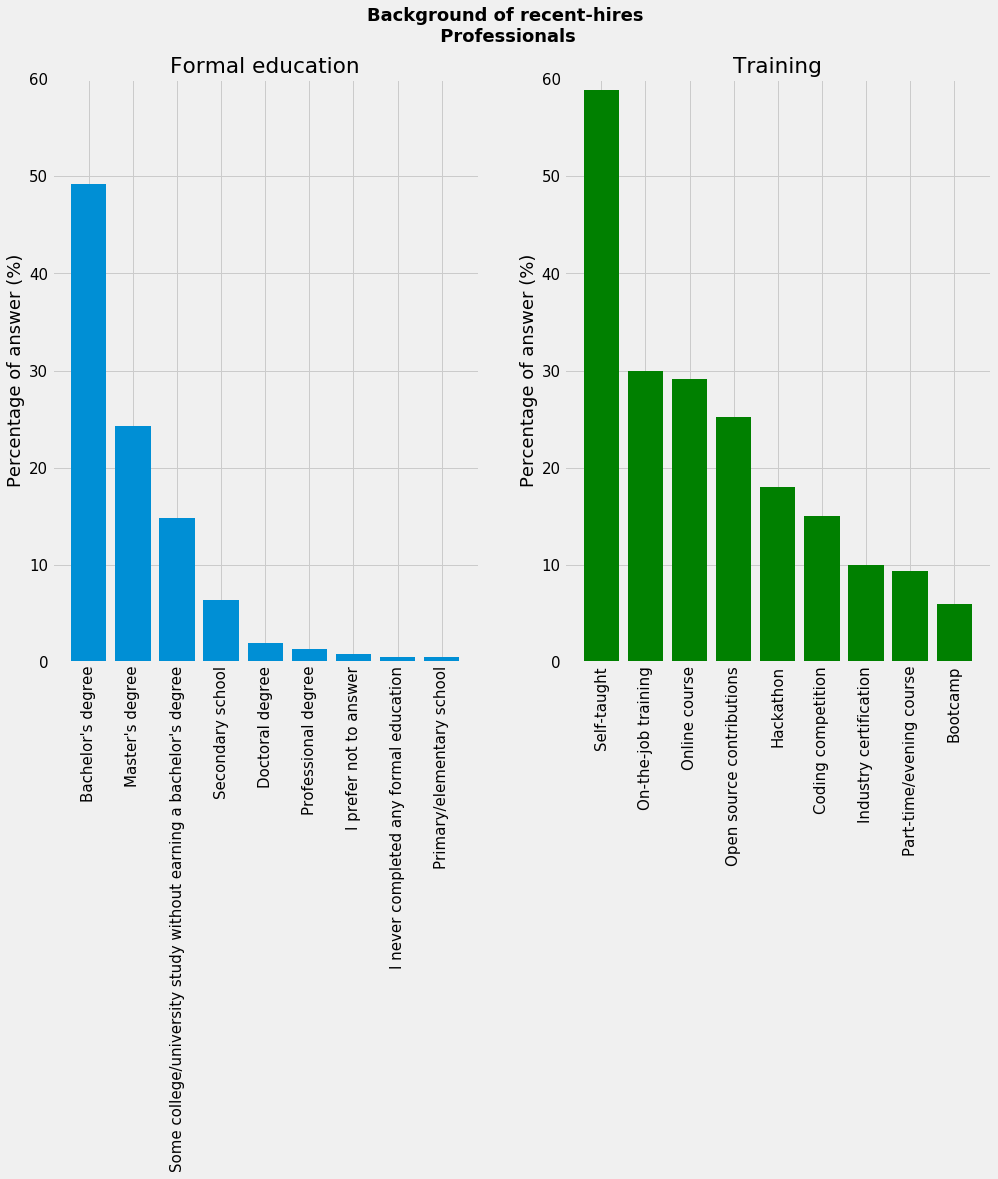

In [17]:
plt.rcParams['figure.figsize']= 15,10

plt.subplot(1,2,1)
plt.suptitle("Background of recent-hires\n Professionals", weight=900)
plt.bar(
    x = FormalEdu.index,
    height = FormalEdu.values*100
)
plt.xticks(rotation=90)
plt.ylabel('Percentage of answer (%)')
plt.title("Formal education")
plt.ylim(top=60)

plt.subplot(1,2,2)
plt.bar(list(EdTypeCount.keys()), perc_EdType*100, color='g')
plt.ylabel('Percentage of answer (%)')
plt.xticks(rotation=90)
plt.title("Training")
plt.ylim(top=60)

In [18]:
txt1 = f'The overwelming majority of recent-hires arrive in the field with a {FormalEdu.index[0]}'
val1 = f'{FormalEdu[0]:.2%}'

txt2 = f" and prefer Self-taught method ({perc_EdType[0]:.2%}). Online course represents ({perc_EdType[2]:.2%}) of informal training responses"

md(
    '>'+txt1+' ('+val1+'), '+txt2
)

>The overwelming majority of recent-hires arrive in the field with a Bachelor's degree (49.20%),  and prefer Self-taught method (58.85%). Online course represents (29.16%) of informal training responses

### __Sucess for Recent Hires by Training (Job Satifaction & Salary)__


#### 1. Job Satisfaction

,Training,Median,Mean
3,Coding competition,7.0,6.949708
0,Online course,7.0,7.018393
2,Self-taught,7.0,7.072956
6,Part-time/evening course,7.0,7.089776
7,Bootcamp,7.0,7.153249
8,Industry certification,8.0,7.152023
1,On-the-job training,8.0,7.177920
5,Open source contributions,8.0,7.236359
4,Hackathon,8.0,7.247413


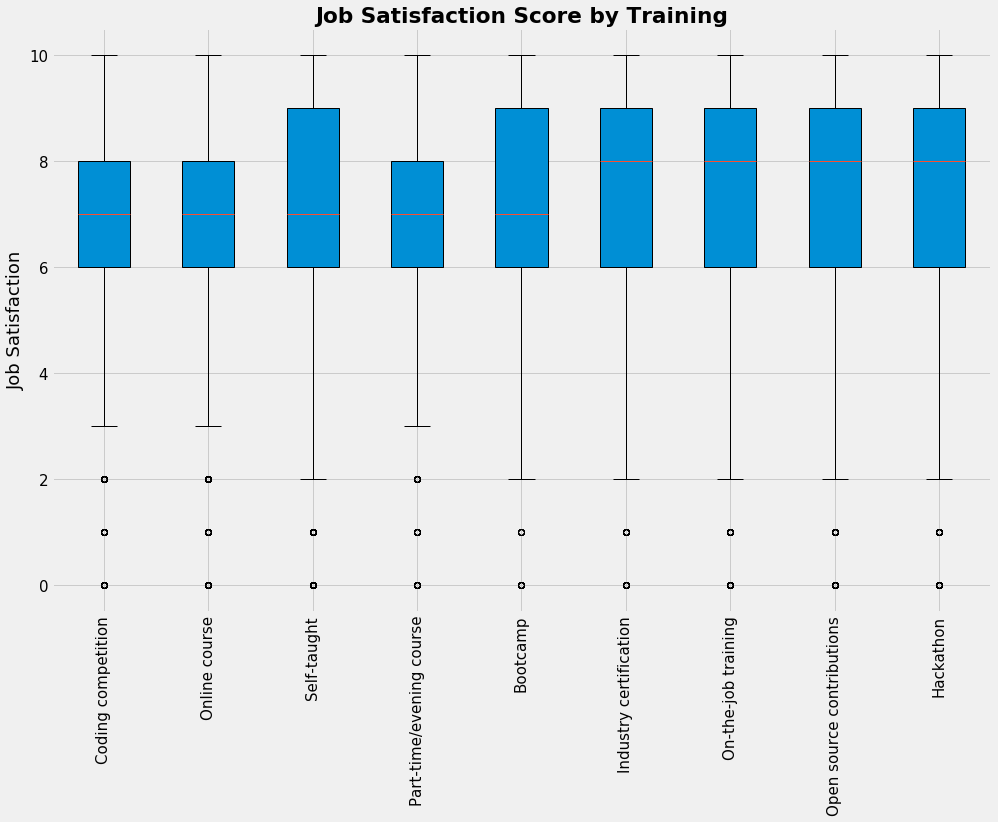

In [19]:
Job_sat = []
jobsat_2_plot = []

for adv, idx in dictEducType.items():
    n_data = df_nhires.reindex(idx)['JobSatisfaction']
    
    jobsat_2_plot.append(n_data.dropna())
    
    Job_sat.append(
        {
            'Training': adv,
            'Median': n_data.median(),
            'Mean':  n_data.mean()
        }
    )


JobSat = pd.DataFrame(Job_sat).sort_values(by=['Median', 'Mean'])
my_order = JobSat.index.tolist() # find order the list of list of salary by Median
jobsat_2_plot = [jobsat_2_plot[x] for x in my_order] # reorganize data_2_plot for boxplot

fig = plt.figure()
ax = fig.add_subplot(111)
bp = plt.boxplot(jobsat_2_plot, patch_artist=True)
ax.set_xticklabels(JobSat['Training'],rotation=90)
plt.ylabel('Job Satisfaction')
plt.title('Job Satisfaction Score by Training', weight='bold')

JobSat


> The satisfaction score are fairly high and similar between the recent-hires training.

#### 2. Salary

1. First explore the different currency reported in the dataset

In [20]:
# filter dataset by removing all missing value in salary and missing Currency
df_nhires = df_nhires.dropna(subset=['Salary', 'Currency']).reset_index(drop=True)

In [21]:
df_nhires['Currency'].value_counts(normalize=True)

U.S. dollars ($)               0.360891
Euros (€)                      0.254710
British pounds sterling (£)    0.112876
Indian rupees (?)              0.067570
Canadian dollars (C$)          0.057917
Polish zloty (zl)              0.029581
Australian dollars (A$)        0.021485
Brazilian reais (R$)           0.020707
Swedish kroner (SEK)           0.016815
Russian rubles (?)             0.016815
Swiss francs                   0.011365
Mexican pesos (MXN$)           0.008719
South African rands (R)        0.007940
Japanese yen (¥)               0.004982
Chinese yuan renminbi (¥)      0.004826
Singapore dollars (S$)         0.002335
Bitcoin (btc)                  0.000467
Name: Currency, dtype: float64

2. Convert Salary to USD equivalent salary
> _CAUTION! This might take a while_ 
<br/>(use fixed exchange rate in ```rates_20200708.cvs``` for speed)

In [22]:
# We are using our custom function ```convert2USB``` to change all currency if not USD.
# df_nhires['SalaryConv_USD'] = df_nhires[['Salary', 'Currency']].apply(lambda x: convert2USD_today(x[1], np.round(x[0])),axis=1)

# For convenience we are using the rate as of July 8th 2020 in '../DataSets/StackOverflow/rates_20200708.csv'
df_rate = pd.read_csv('../DataSets/StackOverflow/rates_20200708.csv', index_col=0)
df_nhires['SalaryConv_USD'] = df_nhires[['Salary', 'Currency']].apply(lambda x: convert2USD(x[0], x[1],df_rate),axis=1)


<a id="outliers"></a>
3. Checking for outliers salary

Text(0.5, 0, 'Survey answer among "Recent Hires"')

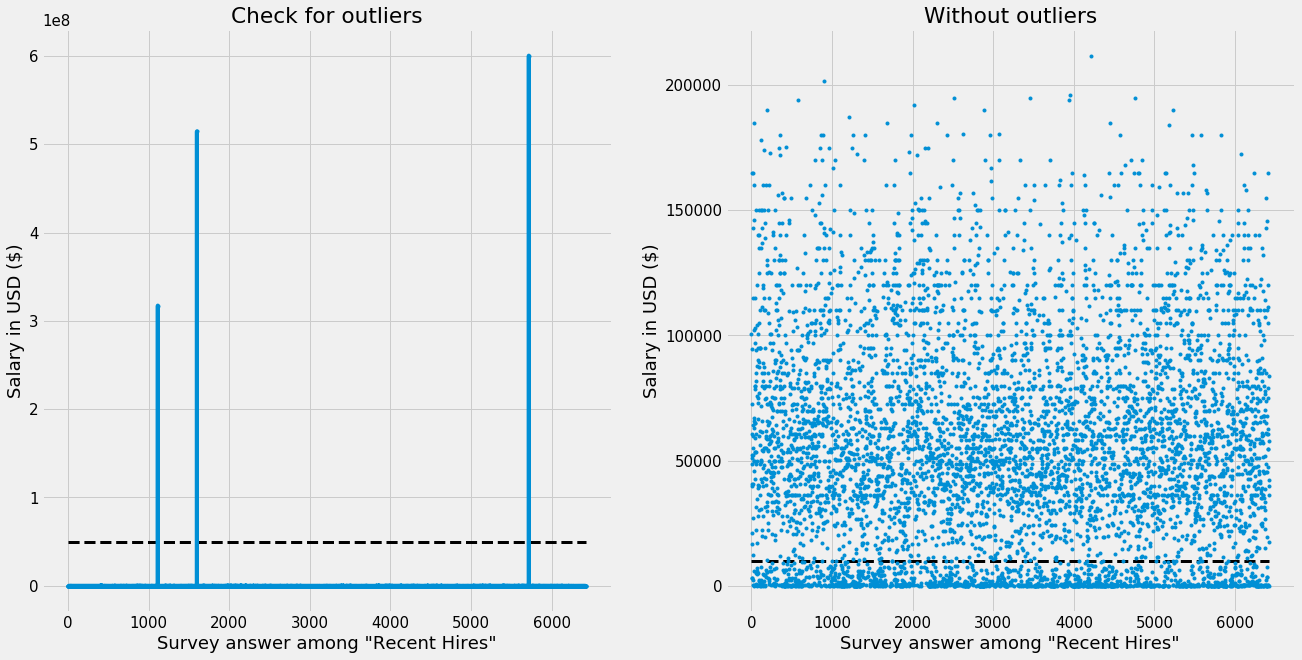

In [23]:
plt.rcParams['figure.figsize']=20, 10

thr_high = 0.5e8
thr_low = 10000

plt.subplot(1,2,1)
df_nhires['SalaryConv_USD'].plot(style='.-', title='Check for outliers')
plt.hlines(y = thr_high, xmin=0, xmax=len(df_nhires), ls='dashed', lw=3)
plt.ylabel('Salary in USD ($)')
plt.xlabel('Survey answer among "Recent Hires"')

plt.subplot(1,2,2)
df_nhires.query(f'SalaryConv_USD < {thr_high}')['SalaryConv_USD'].plot(style='.', title='Without outliers')
plt.hlines(y = thr_low, xmin=0, xmax=len(df_nhires), ls='dashed', lw=3)
plt.ylabel('Salary in USD ($)')
plt.xlabel('Survey answer among "Recent Hires"')

> __remove outliers in salary__ with threshold over USD 500000

> After converting the salaries to USD and filtering out the few outliers, there is still a very high representation of low level salary that should be investigated further. We decided to remove the respondents with USD Salary < 10000.

In [24]:
df_filtered = df_nhires.query(f'(SalaryConv_USD < {thr_high}) & (SalaryConv_USD > {thr_low})').reset_index(drop=True)

4. Distribution of salary over all "Recent Hires"

Text(0, 0.5, 'Number of respondent')

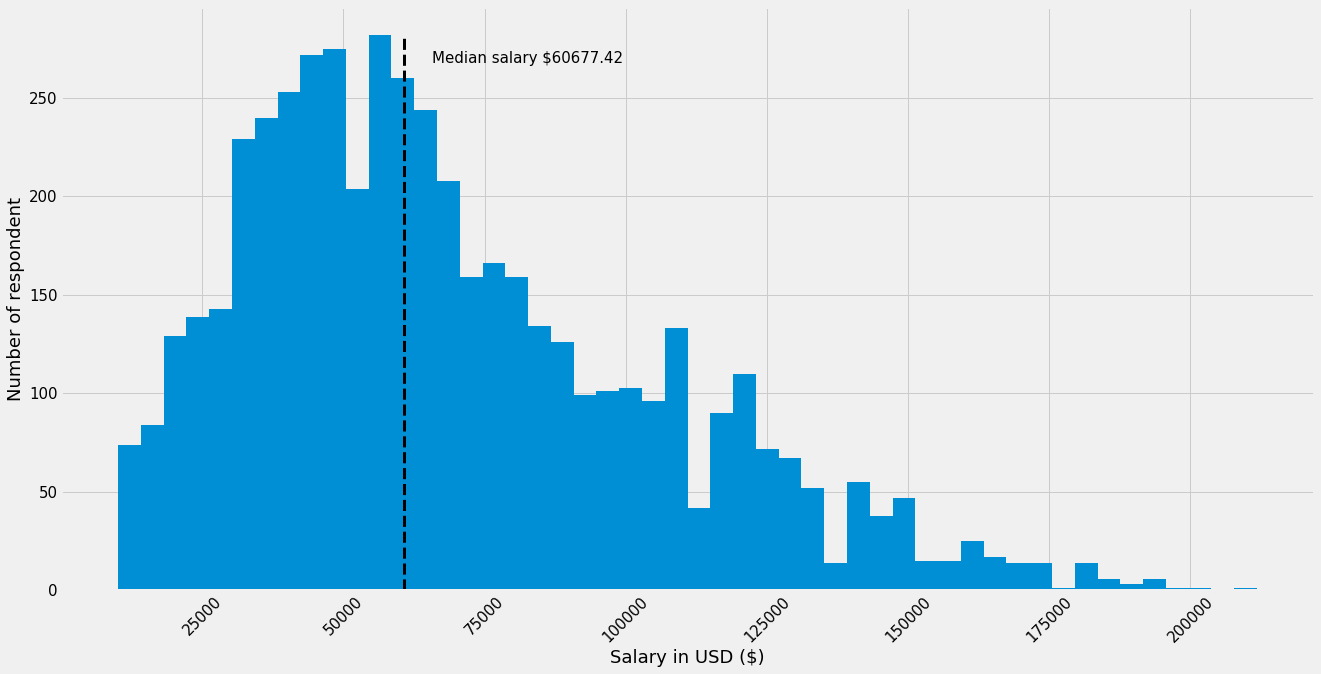

In [25]:
sal_median = df_filtered['SalaryConv_USD'].median()

df_filtered['SalaryConv_USD'].hist(bins=50, xrot=45)
topLim = pd.cut(df_filtered['SalaryConv_USD'],50).value_counts().max()

plt.vlines(x = sal_median, ymin=0, ymax=topLim, linestyles='--', lw=3)
plt.text(sal_median+5000, topLim-topLim*0.05, f'Median salary ${sal_median:.2f}')
plt.xlabel('Salary in USD ($)')
plt.ylabel('Number of respondent')

,Advice,Median,Mean,Std
3,Coding competition,58250.322581,66063.473445,34635.037345
1,On-the-job training,60000.000000,68458.665213,35761.452256
2,Self-taught,60200.212959,68061.158198,35650.887983
5,Open source contributions,60677.419355,68379.839343,36145.064053
0,Online course,62063.076186,69812.474068,35666.034680
4,Hackathon,62376.844632,68586.737333,34764.513082
7,Bootcamp,63000.000000,69303.717808,33471.202244
8,Industry certification,63104.516129,71318.954870,35837.690127
6,Part-time/evening course,65891.373728,73541.037485,33004.985192


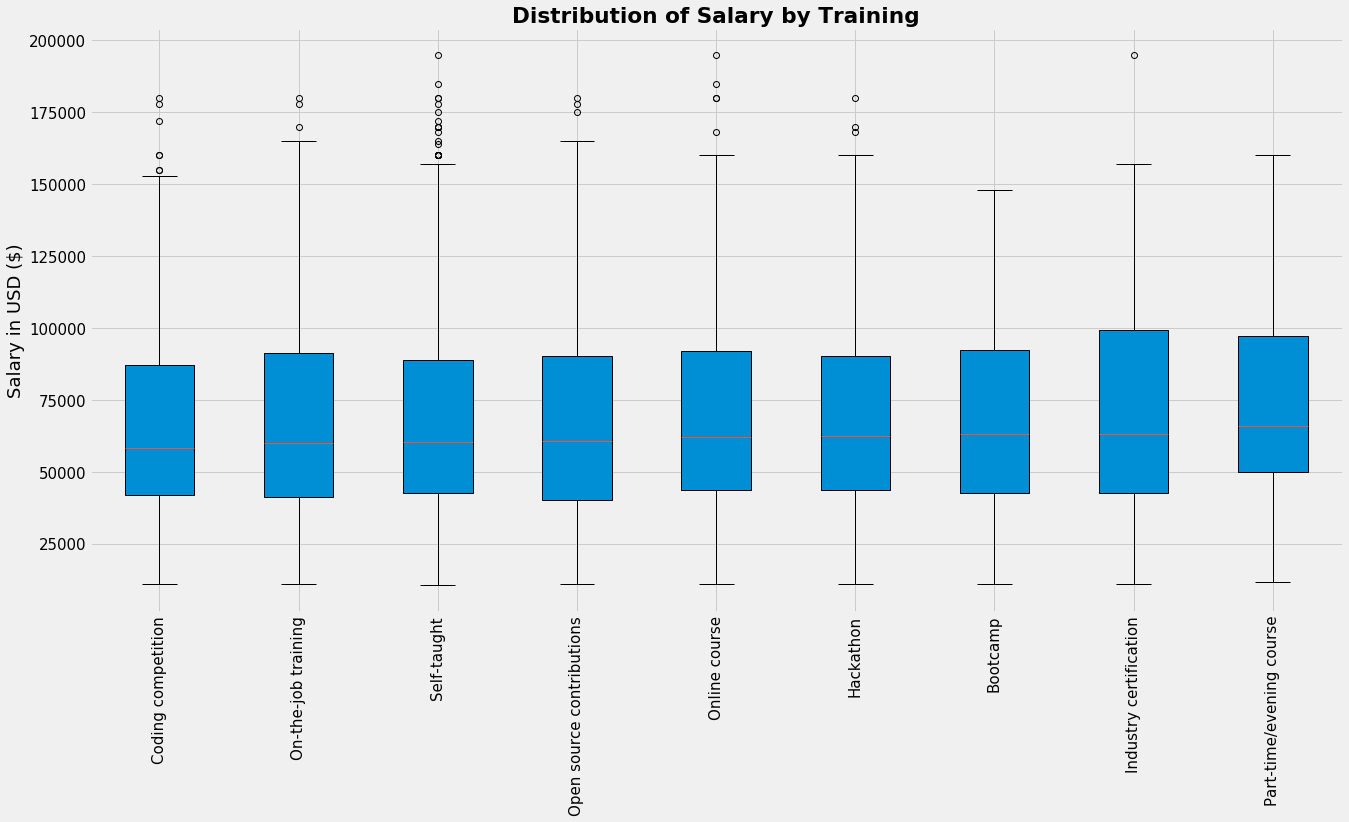

In [26]:
Sal_per_Adv = []
sal_2_plot = []

for adv, idx in dictEducType.items():
    sal = df_filtered.reindex(idx)['SalaryConv_USD']
    
    sal_2_plot.append(sal.dropna())
    
    Sal_per_Adv.append(
        {
            'Advice': adv,
            'Median': sal.median(),
            'Mean':  sal.mean(),
            'Std': sal.std()
        }
    )
    
Sal_per_Adv = pd.DataFrame(Sal_per_Adv).sort_values(['Median','Mean'])
my_order = Sal_per_Adv.index.tolist() # find order the list of list of salary by Median
sal_2_plot = [sal_2_plot[x] for x in my_order] # reorganize data_2_plot for boxplot

fig = plt.figure()
ax = fig.add_subplot(111)
bp = plt.boxplot(sal_2_plot, patch_artist=True)
ax.set_xticklabels(Sal_per_Adv['Advice'],rotation=90)
plt.ylabel('Salary in USD ($)')
plt.title('Distribution of Salary by Training', weight='bold')

Sal_per_Adv

> The boxplots above show __no differences__ in salaries based on the respondent training.

### __Focus on Data Scientist specifically__

In [27]:
# who is a data scientist?
dict_devTypes = getChoices(df_nhires['DeveloperType'])
list(dict_devTypes.keys())

['Other',
 'Embedded applications/devices developer',
 'Web developer',
 'Mobile developer',
 'Quality assurance engineer',
 'Graphics programming',
 'Desktop applications developer',
 'DevOps specialist',
 'Developer with a statistics or mathematics background',
 'Systems administrator',
 'Data scientist',
 'Graphic designer',
 'Database administrator',
 'Machine learning specialist']

> We decided to define data scientist as "Data Scientist" and "Machine learning specialist"

In [28]:
# finding the indices of these unique respondent
idx_dataSci = list(set(dict_devTypes['Data scientist']+dict_devTypes['Machine learning specialist']))

# recent-hires data scientist
df_dataSci = df_nhires.reindex(idx_dataSci)

md(
    f'We identified only __{len(df_dataSci)}__ recent-hires data scientists'
)


We identified only __567__ recent-hires data scientists

#### Formal education and Training for recent-hires Data Scientists

In [29]:
dataSciEdu = getChoices(df_dataSci['FormalEducation'])
dataSciEdu_perc = {k: len(v)/len(df_dataSci) for k, v in dataSciEdu.items()}
dataSciEdu_perc = dict(sorted(dataSciEdu_perc.items(), key=lambda x: x[1], reverse=True))

dataSciTra = getChoices(df_dataSci['EducationTypes'])
dataSciTra_perc = {k: len(v)/len(df_dataSci) for k, v in dataSciTra.items()}
dataSciTra_perc = dict(sorted(dataSciTra_perc.items(), key=lambda x: x[1], reverse=True))

(0.0, 70)

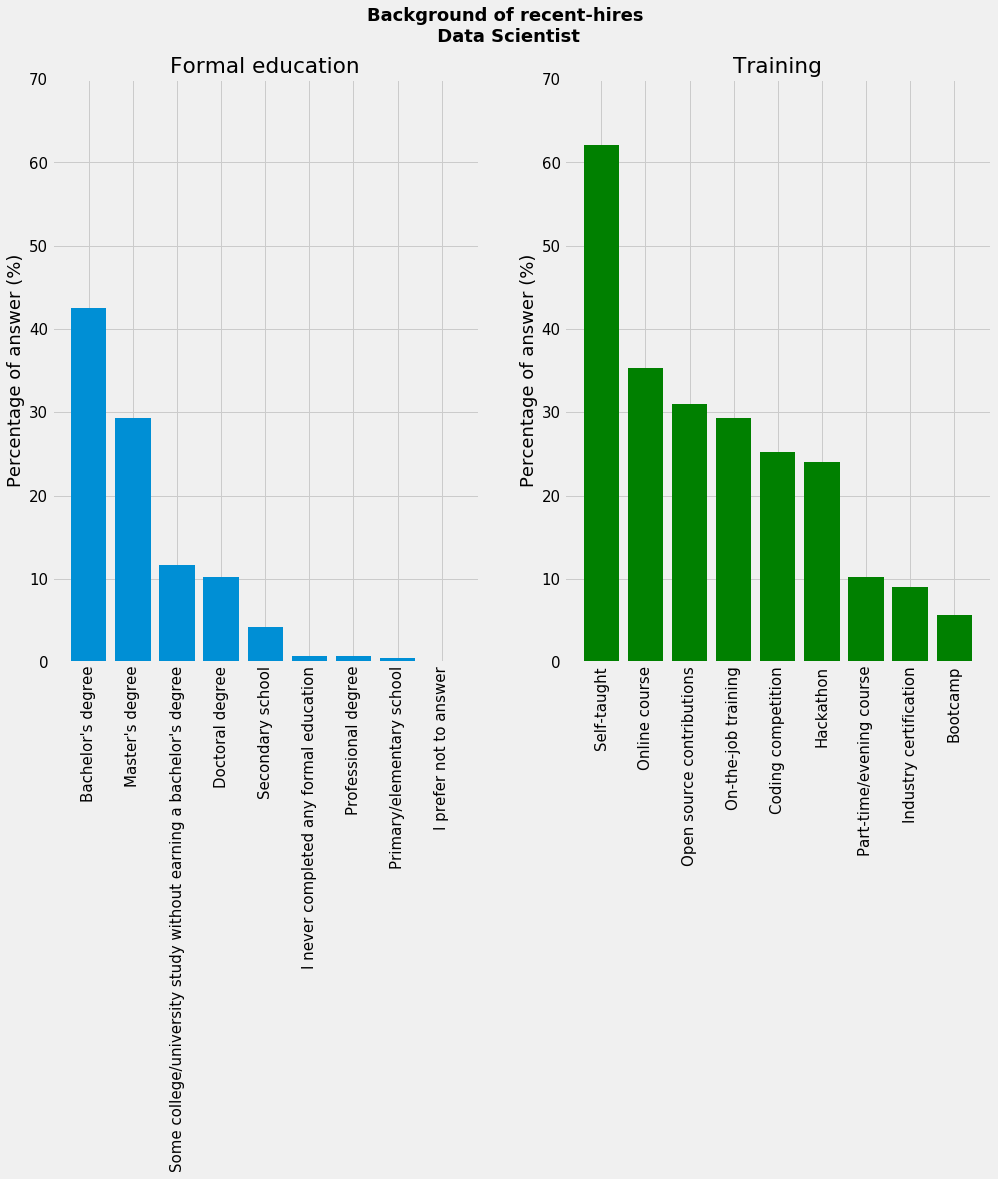

In [30]:
plt.rcParams['figure.figsize']= 15,10

plt.subplot(1,2,1)
plt.suptitle("Background of recent-hires\n Data Scientist", weight=900)
plt.bar(
    x=list(dataSciEdu_perc.keys()),
    height = [x*100 for x in list(dataSciEdu_perc.values())]
)
plt.xticks(rotation=90)
plt.ylabel('Percentage of answer (%)')
plt.title("Formal education")
plt.ylim(top=70)

plt.subplot(1,2,2)
plt.bar(
    x=list(dataSciTra_perc.keys()), 
    height= [x*100 for x in list(dataSciTra_perc.values())],
    color='g'
)

plt.ylabel('Percentage of answer (%)')
plt.xticks(rotation=90)
plt.title("Training")
plt.ylim(top=70)

In [31]:
txt1 = list(dataSciEdu_perc.keys())[0]
val1 = dataSciEdu_perc[txt1]
txt2 = list(dataSciTra_perc.keys())[0]
val2 = dataSciTra_perc[txt2]

md(
    f'The highest degree of the majority of recent-hires data scientist is: {txt1} ({val1:.2%})'
    +'<br/>'
    +f'The prefered unformal training of the majority of recent-hires data scientist is: {txt2} ({val2:.2%})'
)

The highest degree of the majority of recent-hires data scientist is: Bachelor's degree (42.50%)<br/>The prefered unformal training of the majority of recent-hires data scientist is: Self-taught (62.08%)

___
## __Section 4. Data Modeling__
Taking Salary as measure of sucsess, how well can we predict individual salaries of all professional with this dataset?

### __Preparing the data for modeling__
 - To enhance the model we chose a wider set of data using all Professional respondents.
 - Since Salary is the outcome that we are trying to model we chose to be really conservative in the quality of this variable by filtering out all observations with missing values. We also chose to drop missing values for _Currency_ since it was essential to convert the Salary to a common currency (no imputation would be reasonable anyway)

In [32]:
n_df = df_pro.dropna(subset=['Salary', 'Currency']).reset_index(drop=True)
df_rate = pd.read_csv('../DataSets/StackOverflow/rates_20200708.csv', index_col=0)
n_df['SalaryConv_USD'] = n_df[['Salary', 'Currency']].apply(lambda x: convert2USD(x[0], x[1],df_rate),axis=1)

> We are using the same thresholds (high and low) used [earlier](#outliers) to filtered the Salary data from outliers

Text(0.5, 0, 'Salary ($)')

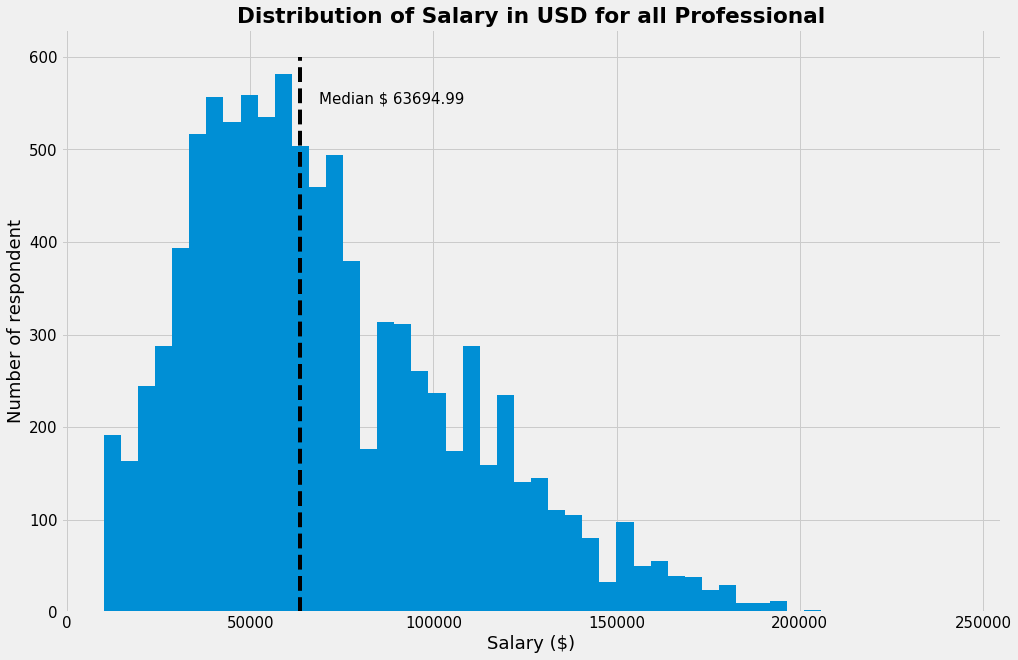

In [33]:
n_df_filtered = n_df.query(f'(SalaryConv_USD < {thr_high}) & (SalaryConv_USD > {thr_low})').reset_index(drop=True)
n_df_filtered['SalaryConv_USD'].hist(bins=50)
sal_med = n_df_filtered['SalaryConv_USD'].median()
plt.vlines(x=sal_med, ymin=0, ymax=600, linestyles='dashed')
plt.text(x=sal_med+5000, y=550, s=f'Median $ {sal_med:.2f}')
plt.title('Distribution of Salary in USD for all Professional', weight='bold')
plt.ylabel('Number of respondent')
plt.xlabel('Salary ($)')

### __Extracting categorical variables and create dummy variables for analysis__

We are extracting all categorical variables to split and encode them into the appropriate unique response. This will enable the use of such categorical variables into or linear estimator.

Missing values are replaced by 0, which will equate to no response over the set of unique choices.

In [34]:
cat_df = n_df_filtered.select_dtypes(include='object')
columns = cat_df.columns.tolist()

In [35]:
X_cat = pd.DataFrame()
for col in columns:
    X_cat = pd.concat([X_cat, createDummyVar(n_df_filtered[col])], axis=1)


In [36]:
X_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9535 entries, 0 to 9534
Columns: 1073 entries, Professional.Professional developer to InterestedAnswers.Strongly disagree
dtypes: int64(1073)
memory usage: 78.1 MB


> By using the customized ```getChoices()``` function we limited the number of dummy variables to 1073 using only the unique choices for each survey questions (instead of 11938 as presented in example)

### __Cleaning numerical variables about Satisfaction__
we are feeling missing values with the median value

In [37]:
# extract numerical variables and explore their content
num_df = n_df_filtered.select_dtypes(exclude='object')
num_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9535 entries, 0 to 9534
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Respondent                 9535 non-null   int64  
 1   CareerSatisfaction         9510 non-null   float64
 2   JobSatisfaction            9501 non-null   float64
 3   HoursPerWeek               4019 non-null   float64
 4   StackOverflowSatisfaction  8998 non-null   float64
 5   Salary                     9535 non-null   float64
 6   ExpectedSalary             0 non-null      float64
 7   SalaryConv_USD             9535 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 596.1 KB


In [38]:
nan_hours = num_df['HoursPerWeek'].isna().sum()/len(num_df)
md(f'> We decided to remove "HoursPerWeek" from the numerical variable since __{nan_hours:.2%}__ of the data were missing')

> We decided to remove "HoursPerWeek" from the numerical variable since __57.85%__ of the data were missing

In [39]:
#clean "numerical" variables: impute missing data with median values
col_sat = ['CareerSatisfaction', 'JobSatisfaction', 'StackOverflowSatisfaction']
df_sat = num_df[col_sat].apply(lambda col:col.fillna(col.median()), axis=0)

> All numerical variables used in the model represent Satisfaction scores that are Ordinal by definition (integer values that represent a ranking system and not a continous scale). The median is therefore more representative of the data and this why we chose this imputation method.

### __Predict model of Salary in USD with linear model__
Following the guidelines provided on [Scikit Learn tutorial page](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html),  we decided to apply a Linear Support Vector Regression estimator to predict the Salary of Professional respondent.

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score

In [41]:
X = pd.concat([df_sat, X_cat], axis=1)
y = n_df_filtered['SalaryConv_USD']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3)

# instantiate
# Lin_mod = LinearRegression(normalize=True)
svr_lin = SVR(kernel='linear', C=1000, gamma='auto')

# fit the model / training
# Lin_mod.fit(X_train, y_train)
svr_lin.fit(X_train, y_train)

# predict test data
# y_pred = Lin_mod.predict(X_test)
y_pred = svr_lin.predict(X_test)
y_pred_train = svr_lin.predict(X_train)

# score the model the test
score_test = r2_score(y_test, y_pred)
score_train = r2_score(y_train, y_pred_train)
md(f'The $r^2$ for the test sample is __{score_test:.2%}__<br/> The $r^2$ for the training sample is __{score_train:.2%}__ <br/>')

The $r^2$ for the test sample is __70.90%__<br/> The $r^2$ for the training sample is __74.68%__ <br/>

### __Model Validation with cross-validation__
We are splitting the data in 10-fold to cross validate our model

In [43]:
from sklearn.model_selection import KFold, cross_val_score

In [44]:
svr_lin_k = SVR(kernel='linear', C=1000, gamma='auto')
k_fold = KFold(n_splits=10)

res = cross_val_score(svr_lin,
                X, 
                y, 
                cv=k_fold, 
                scoring='r2', 
                n_jobs=-1)


In [45]:
md(f'Our linear model account for __{res.mean():.2%}__ of the variance of the Salary of the test sample')

Our linear model account for __70.57%__ of the variance of the Salary of the test sample

  
---
## __Section 5. Evaluate the results__

Since the model is moderately relevant to predict salary (over 70% of the s) we should investigate further what we can learn from the model.

### __Which features carries the most weight in our linear model?__
We are eploring the coedfficient of our SVR linear model to present the top 10 most important features in predicting the Salary of the respondent

In [46]:
SVR_coef = pd.DataFrame()
SVR_coef['Features'] = X.columns
SVR_coef['coef'] = svr_lin.coef_[0]
SVR_coef['abs.coef'] = np.abs(svr_lin.coef_[0])

SVR_coef = SVR_coef.sort_values('abs.coef', ascending=False)
SVR_coef[:10]

,Features,coef,abs.coef
9,Country.United States,44415.140873,44415.140873
534,Currency.Swiss francs,25334.635711,25334.635711
29,Country.Switzerland,24334.635711,24334.635711
536,Currency.Polish zloty (zl),-18648.566921,18648.566921
45,Country.Ireland,17600.454917,17600.454917
228,YearsCodedJob.Less than a year,-17132.618105,17132.618105
41,Country.Poland,-15525.004170,15525.004170
13,Country.Germany,15284.080664,15284.080664
10,Country.Israel,14352.144002,14352.144002
214,YearsCodedJob.1 to 2 years,-14142.346683,14142.346683


> Besides differences in the preparation of the data and the choice of model in this analysis compared to the exrecise presented in the Udacity DataScience Nanodegree, the country of residence and the experince as a coder keep being the most relevant factor determining the salary of the respondent.

### __Looking closer at 'Country' and 'YearsCodedJob'__

In [47]:
# reorganize YearsCodedJob chronologically
list_years = df_filtered['YearsCodedJob'].value_counts().index.tolist()
list_years.sort(key = lambda x: int(x.split(' ')[0]) if not x.startswith('L') else 0)

Text(0.5, 0, 'Salary in USD')

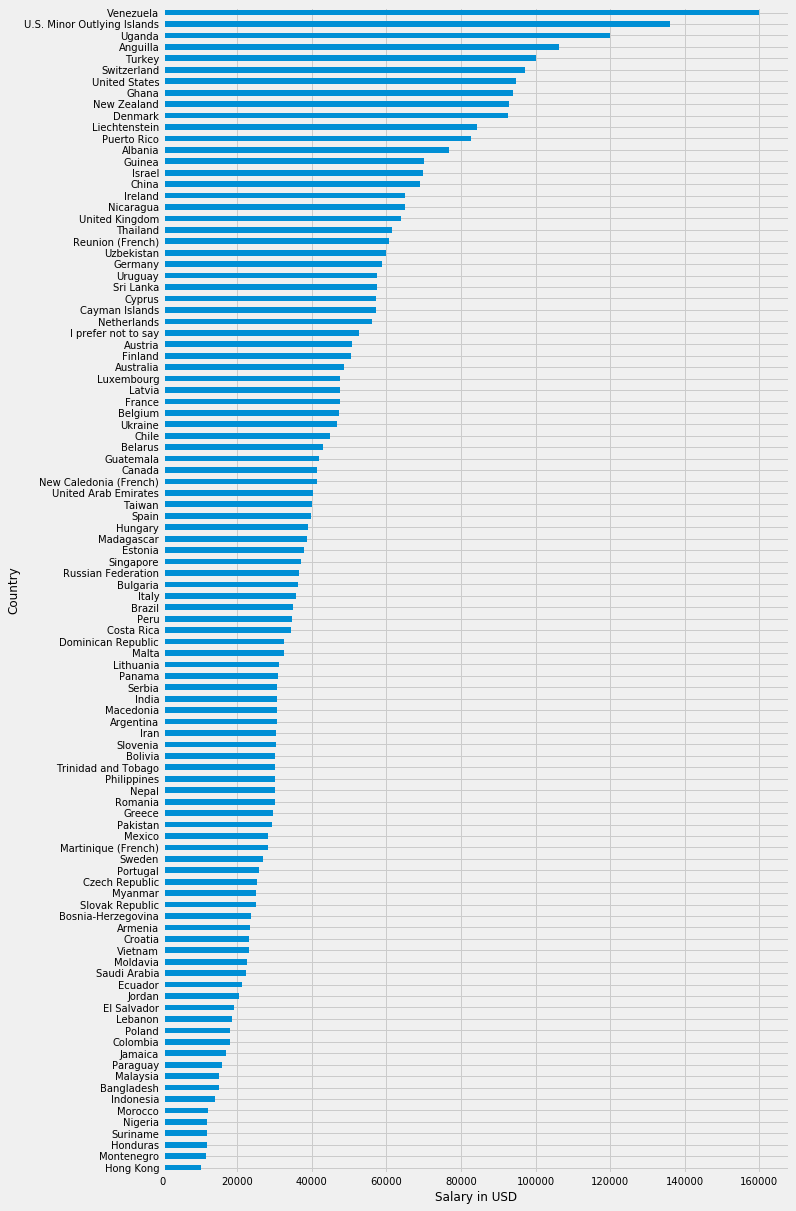

In [48]:
plt.rcParams['figure.figsize']=10,20
plt.rcParams['font.size']=10
df_filtered.groupby(['Country'])['SalaryConv_USD'].mean().sort_values().plot(kind='barh')
plt.xlabel('Salary in USD')

Text(0, 0.5, 'Salary in USD')

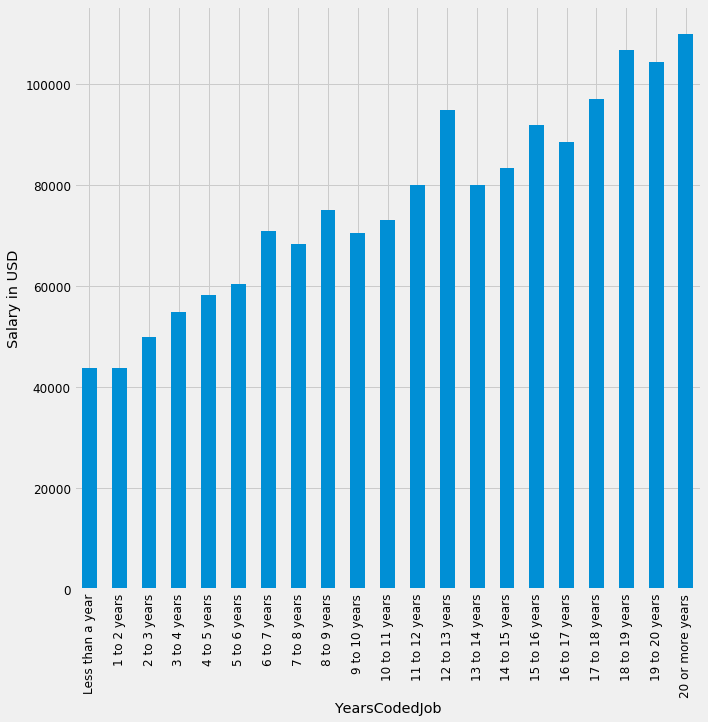

In [49]:
# plot median salary per years of experience
plt.rcParams['figure.figsize']=10,10
plt.rcParams['font.size']=12
df_filtered.groupby(['YearsCodedJob'])['SalaryConv_USD'].median().reindex(list_years).plot(kind='bar')
plt.ylabel('Salary in USD')

---
## __Section 6. Deployment__
not applicable in this example